In [2]:
import sys
import os
os.environ['USE_PYGEOS'] = '0'
import gc
import collections
from pathlib import Path

import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams, cycler
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import geopandas as gpd
from statsmodels.tsa.seasonal import seasonal_decompose

import numpy as np
import xarray as xr
from xeofs.xarray import EOF
import rioxarray

import dask
import distributed

import scipy
from scipy import signal
import cftime
from shapely.geometry import mapping
from xarrayutils.utils import linear_trend, xr_linregress
import pandas as pd
import cmocean

In [3]:
# FIXIT: Jupyter Lab scheduler view for Dask not working
client = distributed.Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 10,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:62665,Workers: 5
Dashboard: http://127.0.0.1:8787/status,Total threads: 10
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:62680,Total threads: 2
Dashboard: http://127.0.0.1:62686/status,Memory: 3.20 GiB
Nanny: tcp://127.0.0.1:62668,


In [4]:
# File path directories

# inDirName = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Get full path of the aislens_emulation directory. All file IO is relative to this path.
main_dir = Path.cwd().parent

DIR_external = 'data/external/'
DIR_processed = 'data/processed/'
DIR_interim = 'data/interim/'

# DATASET FILEPATHS
# Ocean model output - E3SM (SORRMv2.1.ISMF), data received from Darin Comeau / Matt Hoffman at LANL
DIR_SORRMv21 = 'data/external/SORRMv2.1.ISMF/regridded_output/'

# INTERIM GENERATED FILEPATHS
DIR_SORRMv21_Interim = 'data/interim/SORRMv2.1.ISMF/iceShelves_dedraft/'

# DATA FILENAMES
FILE_SORRMv21 = 'Regridded_SORRMv2.1.ISMF.FULL.nc'

# Ice shelf basin/catchment definitions
FILE_iceShelvesShape = 'iceShelves.geojson'

In [6]:
FILE_SORRMv21_RAW = 'SORRMv2.1.ISMF.nc'

In [5]:
yr1 = 300
yr2 = 900
SORRMv21 = xr.open_dataset(main_dir.parent / 'aislens_emulation/' / DIR_external / 'SORRMv2.1.ISMF/regridded_output/' / FILE_SORRMv21, chunks={"Time":36})
SORRMv21_flux = SORRMv21.timeMonthly_avg_landIceFreshwaterFlux[yr1*12:yr2*12]
SORRMv21_draft = SORRMv21.timeMonthly_avg_ssh

In [7]:
sorrmv21_raw = xr.open_dataset('/Users/smurugan9/research/aislens/aislens_emulation/data/external/SORRMv2.1.ISMF/tmp-folder-move-files/SORRMv2.1.ISMF.nc')

In [10]:
SORRMv21_flux.max().compute()

<xarray.DataArray 'timeMonthly_avg_landIceFreshwaterFlux' ()>
array(0.00108586)

In [11]:
SORRMv21_flux.min().compute()

<xarray.DataArray 'timeMonthly_avg_landIceFreshwaterFlux' ()>
array(-8.76627991e-06)

In [13]:
SORRMv21_draft.min().compute()

<xarray.DataArray 'timeMonthly_avg_ssh' ()>
array(-2027.00491096)

(-2000.0, 0.0)

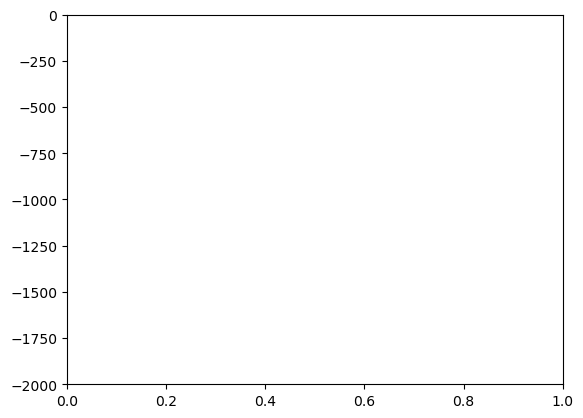

In [15]:
plt.figure()

plt.ylim(-2000,0)


# Draft Dependence of ice shelves
This section considers the relationship between freshwater flux and draft (`ssh` variable from the ocean model output is used as a proxy here)
Scatterplots for all the ice shelf regions are plotted using `src/plot_draft_dependence.py`


In [23]:
#draft_params = xr.open_dataset(main_dir.parent / 'aislens_emulation/' / DIR_interim / 'SORRMv2.1.ISMF/iceShelves_dedraft/iceShelfRegions/iceshelves_draft_dependence_parameters_total.nc')
draft_params = xr.open_dataset(main_dir.parent / 'aislens_emulation/' / DIR_interim / 'SORRMv2.1.ISMF/iceShelves_dedraft/ICESHELVES_AIS_RGRS.nc')

In [24]:
draft_params

<xarray.Dataset>
Dimensions:                                (x: 601, y: 601)
Coordinates:
    Time                                   object ...
  * x                                      (x) float64 -3e+06 ... 3e+06
  * y                                      (y) float64 -3e+06 ... 3e+06
    lat                                    (y, x) float64 ...
    lon                                    (y, x) float64 ...
    spatial_ref                            int64 ...
Data variables:
    timeMonthly_avg_landIceFreshwaterFlux  (y, x) float64 ...

2024-02-13 05:56:42,031 - tornado.application - ERROR - Exception in callback <bound method SystemMonitor.update of <SystemMonitor: cpu: 0 memory: 28 MB fds: 209>>
Traceback (most recent call last):
  File "/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/tornado/ioloop.py", line 921, in _run
    val = self.callback()
  File "/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/distributed/system_monitor.py", line 134, in update
    net_ioc = psutil.net_io_counters()
  File "/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/psutil/__init__.py", line 2114, in net_io_counters
    rawdict = _psplatform.net_io_counters()
OSError: [Errno 12] Cannot allocate memory
ERROR:tornado.application:Exception in callback <bound method SystemMonitor.update of <SystemMonitor: cpu: 0 memory: 28 MB fds: 209>>
Traceback (most recent call last):
  File "/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/tornado/ioloop.